In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

### 2.2 The Marcenko–Pastur Theorem

#### Snippet 2.1 The Marcenko–Pastur PDF

In [3]:
def mpPDF(var, q, pts):
    # Marcenko-Pastur pdf
    # q = T/N
    # print(var, q, pts)
    eMin, eMax = var*(1-(1./q)**.5)**2, var*(1+(1./q)**.5)**2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf = pd.Series(pdf, index=eVal)
    return pdf

#### Snippet 2.2 Testing the Marcenko–Pastur Theorem

In [4]:
def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec[:, indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec

In [5]:
def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape) == 1:
        obs = obs.reshape(-1,1)
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1,1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)  # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

In [6]:
x = np.random.normal(size=(10000, 1000))
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.01)  # empirical pdfEnd Box

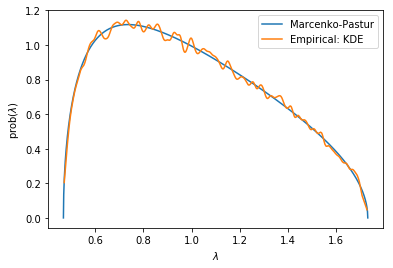

In [7]:
plt.plot(pdf0)
plt.plot(pdf1)
plt.legend(['Marcenko-Pastur', 'Empirical: KDE'])
plt.xlabel(r'$\lambda$')
plt.ylabel(r'prob($\lambda$)')
plt.show()

### 2.3 Random Matrix with Signal

#### Snippet 2.3 Add Signal to a Random Covariance Matrix

In [8]:
def getRndCov(nCols, nFacts):
    w = np.random.normal(size=(nCols,nFacts))
    cov = np.dot(w, w.T)  # random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) # full rank cov
    return cov

In [9]:
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std, std)
    corr[corr<-1], corr[corr>1] = -1, 1  # numerical error
    return corr

In [10]:
alpha, nCols, nFact, q = .995, 1000, 100, 10
cov = np.cov(np.random.normal(size=(nCols*q,nCols)), rowvar=0)
cov = alpha*cov+(1-alpha)*getRndCov(nCols, nFact) # noise+signal
corr0 = cov2corr(cov)
eVal0, eVec0 = getPCA(corr0)

### 2.4 Fitting the Marcenko–Pastur Distribution

#### Snippet 2.4 Fitting the Marcenko–Pastur PDF

In [11]:
def errPDFs(var, eVal, q, bWidth, pts=1000):
    # Fit error
    # print(var, q, pts)
    var = var[0]
    pdf0 = mpPDF(var, q, pts) # theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) # empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    return sse

In [12]:
def findMaxEval(eVal, q, bWidth):
    # Find max random eVal by fitting Marcenko’s dist
    out = minimize(lambda *x: errPDFs(*x), .5, args=(eVal, q, bWidth),
                   bounds=((1E-5, 1-1E-5),))
    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

In [13]:
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

In [14]:
print(eMax0, var0, nFacts0)

1.1733994469068472 0.6773042223654825 100


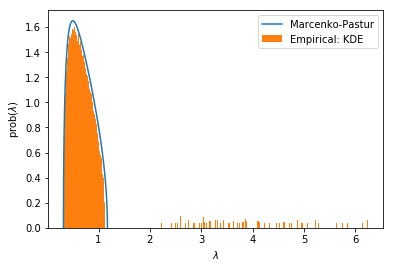

In [15]:
pdf0 = mpPDF(var0, q, pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.01)  # empirical pdfEnd Box

plt.plot(pdf0)
plt.bar(pdf1.index, pdf1.values, 0.01, color='tab:orange')
plt.legend(['Marcenko-Pastur', 'Empirical: KDE'])
plt.xlabel(r'$\lambda$')
plt.ylabel(r'prob($\lambda$)')
plt.show()

### 2.5 Denoising

### 2.5.1 Constant Residual Eigenvalue Method

#### Snippet 2.5 Denoising by Constant Residual Eigenvalue

In [16]:
def denoisedCorr(eVal, eVec, nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum() / float(eVal_.shape[0] - nFacts)
    eVal_ = np.diag(eVal_)
    corr1 = np.dot(eVec, eVal_).dot(eVec.T)
    corr1 = cov2corr(corr1)
    return corr1

In [17]:
corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)

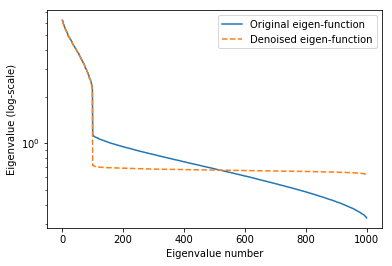

In [18]:
cnt0 = sorted(np.diag(eVal0), reverse=True)
cnt1 = sorted(np.diag(eVal1), reverse=True)
plt.plot(cnt0)
plt.plot(cnt1, '--')
plt.xlabel('Eigenvalue number')
plt.ylabel('Eigenvalue (log-scale)')
plt.legend(['Original eigen-function', 'Denoised eigen-function'])
plt.yscale('log')
plt.show()

#### Snippet 2.6 Denoising by Targeted Shrinkage

In [19]:
def denoisedCorr2(eVal, eVec, nFacts, alpha=0):
    # Remove noise from corr through targeted shrinkage
    eValL, eVecL = eVal[:nFacts, :nFacts], eVec[:, :nFacts]
    eValR, eVecR = eVal[nFacts:, nFacts:], eVec[:, nFacts:]
    corr0 = np.dot(eVecL, eValL).dot(eVecL.T)
    corr1 = np.dot(eVecR, eValR).dot(eVecR.T)
    corr2 = corr0 + alpha*corr1 + (1 - alpha)*np.diag(np.diag(corr1))
    return corr2

In [20]:
corr1 = denoisedCorr2(eVal0, eVec0, nFacts0, alpha=.5)
eVal1, eVec1 = getPCA(corr1)

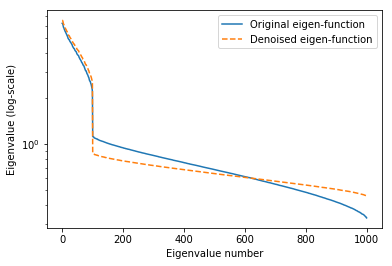

In [21]:
cnt0 = sorted(np.diag(eVal0), reverse=True)
cnt1 = sorted(np.diag(eVal1), reverse=True)
plt.plot(cnt0)
plt.plot(cnt1, '--')
plt.xlabel('Eigenvalue number')
plt.ylabel('Eigenvalue (log-scale)')
plt.legend(['Original eigen-function', 'Denoised eigen-function'])
plt.yscale('log')
plt.show()

### 2.6 Detoning


### 2.7 Experimental Results

#### 2.7.1 Minimum Variance Portfolio

#### Snippet 2.7 Generating a Block-Diagonal Covariance Matrix and a Vector of Means

In [22]:
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

In [23]:
def corr2cov(corr, std):
    cov = corr*np.outer(std, std)
    return cov

In [24]:
def formBlockMatrix(nBlocks, bSize, bCorr):
    block = np.ones((bSize, bSize))*bCorr
    block[range(bSize), range(bSize)] = 1
    corr = block_diag(*([block]*nBlocks))
    return corr

In [25]:
def formTrueMatrix(nBlocks, bSize, bCorr):
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0[cols].loc[cols].copy(deep=True)
    std0 = np.random.uniform(.05, .2, corr0.shape[0])
    cov0 = corr2cov(corr0, std0)
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1,1)
    return mu0, cov0

In [26]:
nBlocks, bSize, bCorr = 10, 50, .5
np.random.seed(0)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)

#### Snippet 2.8 Generating the Empirical Covariance Matrix

In [27]:
def simCovMu(mu0, cov0, nObs, shrink=False):
    x = np.random.multivariate_normal(mu0.flatten(), cov0, size=nObs)
    mu1 = x.mean(axis=0).reshape(-1, 1)
    if shrink:
        cov1 = LedoitWolf().fit(x).covariance_
    else:
        cov1 = np.cov(x, rowvar=0)
    return mu1, cov1

#### Snippet 2.9 Denoising of the Empirical Covariance Matrix

In [28]:
def deNoiseCov(cov0, q, bWidth):
    corr0 = cov2corr(cov0)
    eVal0, eVec0 = getPCA(corr0)
    eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth)
    nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
    cov1 = corr2cov(corr1, np.diag(cov0)**.5)
    return cov1

#### Snippet 2.10 Denoising of the Empirical Covariance Matrix

In [29]:
def optPort(cov, mu=None):
    inv = np.linalg.inv(cov)
    ones = np.ones(shape=(inv.shape[0], 1))
    if mu is None:
        mu=ones
    w = np.dot(inv, mu)
    w /= np.dot(ones.T, w)
    return w

In [ ]:
nObs, nTrials, bWidth, shrink, minVarPortf = \
    1000, 1000, .01, False, True
w1 = pd.DataFrame(columns=range(cov0.shape[0]),
                  index=range(nTrials), dtype=float)
w1_d = w1.copy(deep=True)
np.random.seed(0)

for i in range(nTrials):
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink=shrink)
    if minVarPortf:
        mu1 = None
    cov1_d = deNoiseCov(cov1, nObs*1./cov1.shape[1], bWidth)
    w1.loc[i] = optPort(cov1, mu1).flatten()
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten()

#### Snippet 2.11 Root-Mean-Square Errors

In [ ]:
w0 = optPort(cov0, None if minVarPortf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis=0)
rmsd = np.mean((w1-w0).values.flatten()**2)**.5  # RMSE
rmsd_d = np.mean((w1_d-w0).values.flatten()**2)**.5  # RMSE
print(rmsd, rmsd_d)